### Comparing the Color of Lenses using data from Sonnenfeild et al's paper

Jenny Kim, Phil Marshall

[This paper(Sonnenfeild et al.)](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/97/meta#apj485108t5) and [this paper(Sonnenfeild et al.)](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/98/meta) contain the information of 56 candidate galaxy-scale lenses that was taken with Canada-France-Hawaii Telescope (CFHT). In addition to comparing the colored lenses with a simple Faber-Jackson scaling implemented by Phil Marshall in the `LensColorComparison.ipynb`, we can also compared the mock data with the real data. In this notebook, we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $g-r$ magnitude, 4) $r-i$ magnitude, and 5) $i-z$ magnitude between the known SDSS values and the colored magnitudes for each lens by drawing a cornerplot. The paper had CFHT magnitude, which had $<0.05$ mag zero point difference to SDSS magnitude. Thus, for the sake of simple calculation, we ignored the differences in this notebook while drawing the cornerplot.

In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import om10
from om10 import plotting
import matplotlib
import corner

First, let's read the catalog and select 200 lenses whose magnitudes are smaller than 23.6. Then, let's paint the lenses.

In [6]:
db = om10.DB(catalog='/Users/Jenny/Desktop/om10fork/om10/data/qso_sample_lens_colored.fits')

OM10: Full db.lenses table contains 200 systems
OM10: Initial db.sample contains 200 systems


The first textfile `../data/1.txt` and the second textfile `../data/2.txt` is from the [third paper of Sonnenfeild et al](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/97/meta#apj485108t5). The third textfile `../data/3.txt` is from the [fourth paper of Sonnenfeild at al](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/98/meta). `../data/1.txt` contains U, G, R, I, Z bands magnitudes, `../data/2.txt` constains redshifts, and `../data/3.txt` contains velocity dispersions. All the files contain LensName, which we used to match the data in different textfiles. The second cell below merges all the information needed.

In [7]:
III_a = np.genfromtxt('../data/SonnenfeildTable1.txt', dtype=str, usecols = (0, 4, 5, 6, 7, 8), invalid_raise=False, missing_values='xxx', usemask=False)
III_b = np.genfromtxt('../data/SonnenfeildTable2.txt', dtype=str, usecols = (0, 1), invalid_raise=False, missing_values='xxx')
IV = np.genfromtxt('../data/SonnenfeildTable3.txt', dtype=str, usecols = (0, 11), invalid_raise=False, missing_values='xxx')

Let's handle the real data using the python data structures. We will read in the values that are necessary, and construct a table so that OM10 could draw the cornerplot using it.

We can also save the whole thing into the textfile by calling `data.write('merged', format='txt')`. This will make this notebook a lot cleaner.

In [11]:
name = np.array([])
redshiftReal = np.array([])
iReal = np.array([])
grReal = np.array([])
riReal = np.array([])
izReal = np.array([])
for (lensName, aIndex) in zip(III_a[:,0], range(len(III_a))):
    if lensName in III_b[:,0]:
        bIndex = np.argwhere(III_b[:,0]==lensName)[0][0]
        if lensName in IV[:,0]:
            VIndex = np.argwhere(IV[:,0]==lensName)[0][0]
            # the redshift sometimes has some problem, so we should handle those problems
            if(IV[VIndex][1].isdigit()):
                name = np.append(name, lensName)
                redshiftReal = np.append(redshiftReal, float(III_b[bIndex][1]))
                iReal = np.append(iReal, float(III_a[aIndex][4]))
                grReal = np.append(grReal, float(III_a[aIndex][2]) - float(III_a[aIndex][3]))
                riReal = np.append(riReal, float(III_a[aIndex][3]) - float(III_a[aIndex][4]))
                izReal = np.append(izReal, float(III_a[aIndex][4]) - float(III_a[aIndex][5]))
#convert every numpy array to list - if not, OM10.plot_sample throws an error
redshift = np.array(redshiftReal.tolist())
iReal = np.array(iReal.tolist())
grReal = np.array(grReal.tolist())
riReal = np.array(riReal.tolist())
izReal = np.array(izReal.tolist())
from astropy.table import Table
data = Table({'MAGI': iReal, 'ZLENS': redshiftReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['MAGI', 'ZLENS', 'GR', 'RI', 'IZ'])

Then, we need to weight the mocked lenses with respect to the parent population. The parent population would be gaussian distributed, and the mean would be given by $np.mean(z)$ and the standard deviation would be given by $np.std(z)$.

The weight could first be calculated by using this formula:

$$\frac { P(redshift) }{ Q(redshift) } $$

where P(redshift) is a y-value of redshift in the parent normal distribution and Q(redshift) is a y-value of redshift in the mock, colored lenses. 

In addition to this, we can use rejection sampling method to make the distribution more like its gaussian population distribution.

Reweighting algorithm is implemented in `gaussian_reweight`.

We only have around 35 valid, real lenses to use to weight the mock lenses. This is not an ideal situation, but still, let's plot the synthetically colored lenses onto the cornerplot with weights.

In [12]:
db.gaussian_reweight(np.mean(redshift), np.std(redshift))

Then, we draw the cornerplot with the synthetically colored OM10 lenses and save to the argument `fig1`. OM10 sometimes throw errors when we use matplotlib because of the `usetex=True` argument, so to be safe, let's set `usetex=False`.

In [13]:
matplotlib.rc('text', usetex=False)
# GR Color index
gr = db.sample['g_SDSS'] - db.sample['r_SDSS']
ri = db.sample['r_SDSS'] - db.sample['i_SDSS']
iz = db.sample['i_SDSS'] - db.sample['z_SDSS']
data = Table({'i_SDSS': db.sample['i_SDSS'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))

fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

Then, we will overlap the synthetically colored samples with the original data. Ideally, the distributions of the data should be similar, and the blue contours and the red contours should have significant overlap.

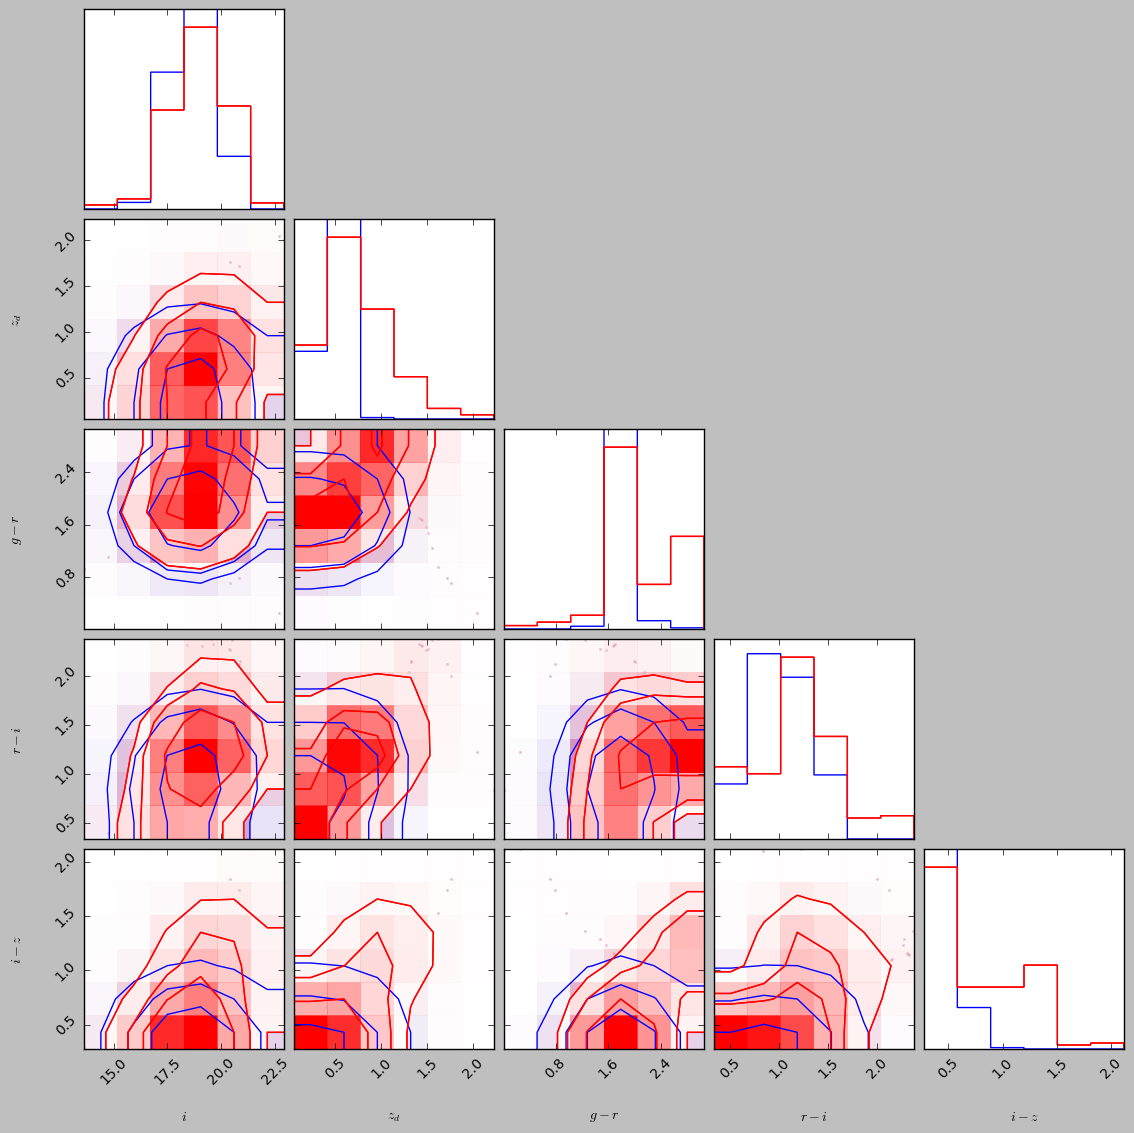

In [15]:
%matplotlib inline
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig1, hist_kwargs=dict(normed=True))

Similar to `lensColorComparison` notebook, Red(the real data) and the blue(synthetically colored data) contours look really similar to each other. This suggests that the synthetic coloring algorithm is reasonable. 